## Import all necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import cufflinks as cf
cf.go_offline()
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,roc_curve,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping
#from regressors import stats
import warnings


In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Load the data

In [3]:
train = pd.read_csv('../input/titanic/train.csv',index_col='PassengerId')
test = pd.read_csv('../input/titanic/test.csv',index_col='PassengerId')

## TRAINING DATA - overview

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [5]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [6]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,714.000,891.000,891.000,891.000
mean,0.384,2.309,29.699,0.523,0.382,32.204
std,0.487,0.836,14.526,1.103,0.806,49.693
min,0.000,1.000,0.420,0.000,0.000,0.000
25%,0.000,2.000,20.125,0.000,0.000,7.910
50%,0.000,3.000,28.000,0.000,0.000,14.454
75%,1.000,3.000,38.000,1.000,0.000,31.000
max,1.000,3.000,80.000,8.000,6.000,512.329


## Data dictionary
### Let's create a data dictionary based on information on kaggle

In [7]:
titanic_dict = {'survived':'survived',
               'Pclass':'Ticket class',
               'sex':'Sex',
               'Age':'Age in years',
               'Sibsp':'# of siblings / spouses aboard the Titanic',
               'parch':'# of parents / children aboard the Titanic',
               'ticket':'Ticket number',
               'Fare':'Passenger fare',
               'cabin':'Cabin number',
               'Embarked':'Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)'}

With data dictionary we can easilly check in any time what our variable means on use for instance on plot instead of variable name.

## TEST DATA - overview

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [9]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.500,0,0,330911,7.829,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000,1,0,363272,7.000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.000,0,0,240276,9.688,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.000,0,0,315154,8.662,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000,1,1,3101298,12.287,NaN,S


In [10]:
test.describe()

,Pclass,Age,SibSp,Parch,Fare
count,418.000,332.000,418.000,418.000,417.000
mean,2.266,30.273,0.447,0.392,35.627
std,0.842,14.181,0.897,0.981,55.908
min,1.000,0.170,0.000,0.000,0.000
25%,1.000,21.000,0.000,0.000,7.896
50%,3.000,27.000,0.000,0.000,14.454
75%,3.000,39.000,1.000,0.000,31.500
max,3.000,76.000,8.000,9.000,512.329


## Missing data on training data

In [11]:
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

We can see that we have got 177 missing values for feature Age, 687 missing values for feature Cabin and 2 missing values for feature Embarked. Let's make a heatmap which sum up the missing data features.

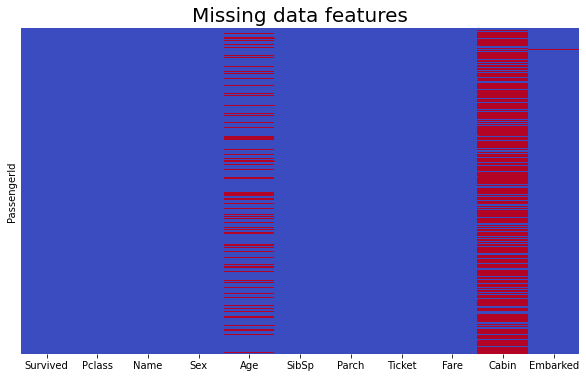

In [12]:
plt.figure(figsize=(10,6))
sns.heatmap(train.isnull(),cbar = False,yticklabels = False,cmap = "coolwarm") 
sns.set(font_scale=1.4)
plt.title('Missing data features',fontsize = 20)
plt.show()

## Exploratory analysis on training set

Now let's make a few visualisations to check the features in the dataset.

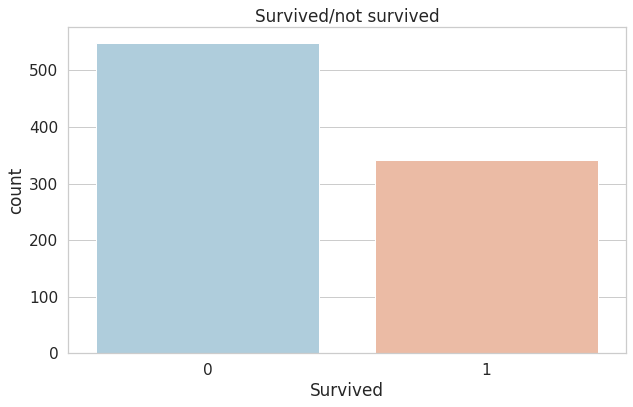

In [13]:
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')
plt.title("Survived/not survived")
plt.show()

We can see that more than 500 passengers survived the disaster but more than 300 passengers dead.
Let's check if there is dependence of sex of passenger who survived or not survived.

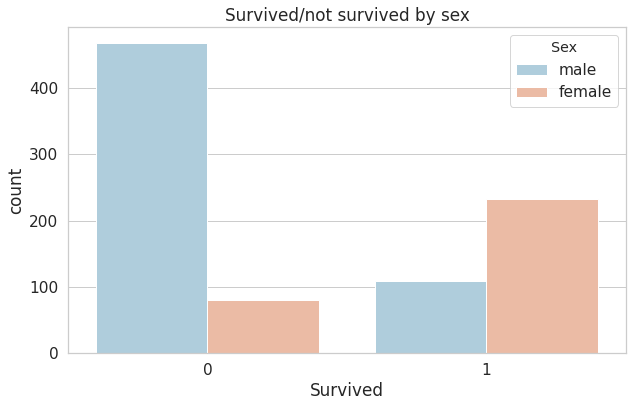

In [14]:
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')
plt.title('Survived/not survived by sex')
plt.show()

When we divided passengers by sex we can notice that twice more women died in the disaster than men and four times more men survived than women.
Now let's check how it look's when we divide survival of passengers by Ticket class.

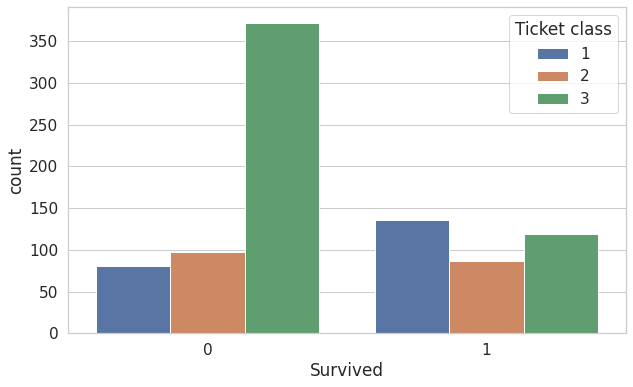

In [15]:
plt.figure(figsize=(10,6))
sns.countplot(x="Survived",data = train, hue = "Pclass")
plt.legend(title = titanic_dict['Pclass'])
plt.show()

We can see from the plot that most passengers bought tickets for third class (more over 400). However from passengers who died in the distaster most passengers bought first class tickets.  
Now let's check the distribution of passengers age.

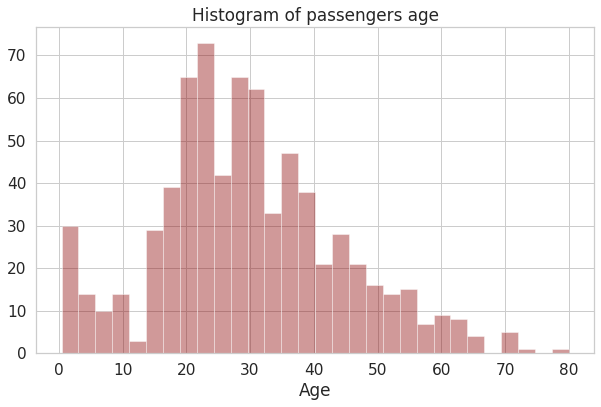

In [16]:
plt.figure(figsize=(10,6))
sns.distplot(train['Age'].dropna(),kde=False,color='darkred',bins=30)
plt.title('Histogram of passengers age')
plt.show()

We can see from the plot that most of passengers were between 20-30 years old.
Let's check with less number of bins.

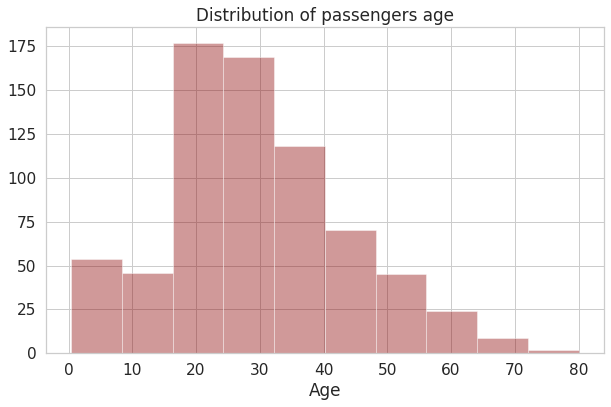

In [17]:
plt.figure(figsize=(10,6))
sns.distplot(train['Age'].dropna(),kde=False,color='darkred',bins=10)
plt.title('Distribution of passengers age')
plt.show()

Now we can confirm that most of passengers were between 20-30 years old.

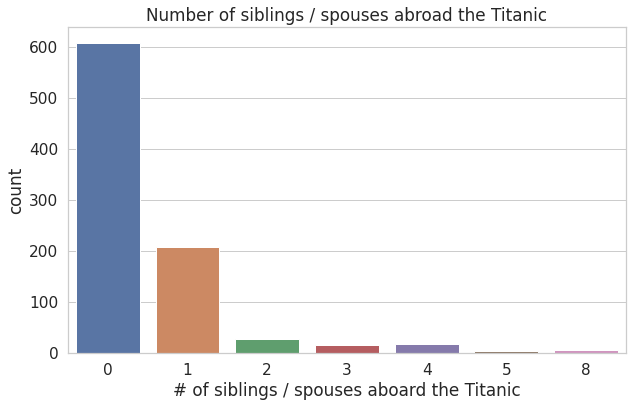

In [18]:
plt.figure(figsize=(10,6))
sns.countplot(x='SibSp',data=train)
plt.xlabel(titanic_dict['Sibsp'])
plt.title("Number of siblings / spouses abroad the Titanic")
plt.show()

We can see from the plot that most of the passengers travelled alone. Around 200 passengers travelled together, possibly a married or couples.
Let's check the distribution of passengers fare.

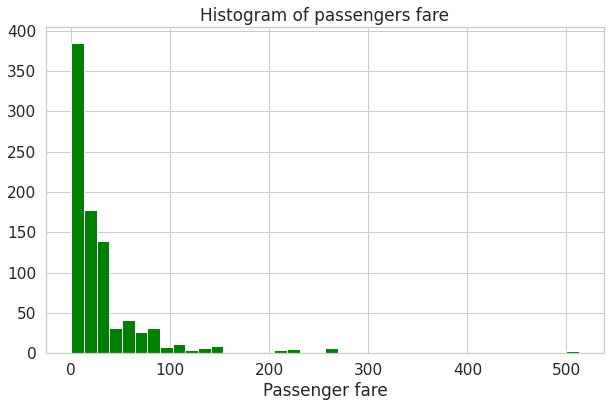

In [19]:
plt.figure(figsize=(10,6))
train['Fare'].hist(color='green',bins=40,figsize=(10,6))
plt.title("Histogram of passengers fare")
plt.xlabel(titanic_dict['Fare'])
plt.show()

Most of passengers as we checked out earlier were travelling in the third class. As we can see from the plot tickets for the third class were not too expensive. There are some outliers, propably some of passengers in first class bought some extra services.
For better understanding of fare distribution let's use a iplot.

In [20]:
train['Fare'].iplot(kind='hist',bins=30,color='green')

## Training data cleaning 

As we saw earlier we have some lacks of data for variable age. 
Let's check how many values are missing and how we can impute missing values. 

In [21]:
train['Age'].isnull().sum()/(train['Age'].count()+train['Age'].isnull().sum())*100

19.865319865319865

We can see that almost 1/5 of passengers don't have information about their age.
Let's make a boxplot to check if age can depend on the passenger class.

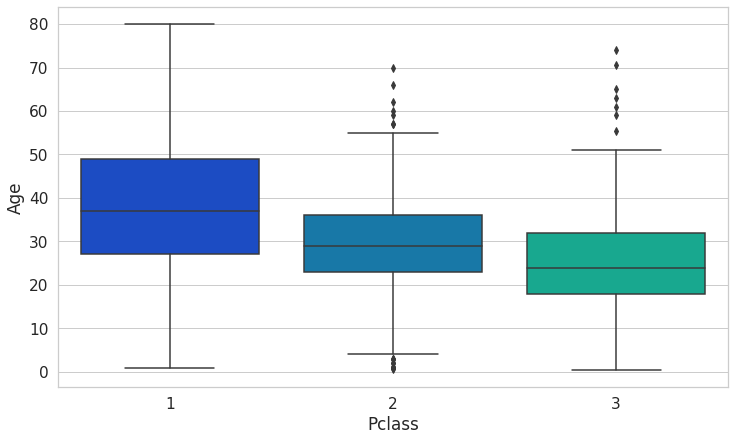

In [22]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

We can see that passengers who bought tickets in first class are older than passengers in other classes. 
We may assume that richer and older passengers are sitting in the first class. 
So then, let's impute missing values for age depending on ticket class.

## Age imputation on training data

In [23]:
train.groupby("Pclass").mean()["Age"]

Pclass
1   38.233
2   29.878
3   25.141
Name: Age, dtype: float64

In [24]:
def age_imputation(column):
    Age = column[0]
    Pclass = column[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return train[train["Pclass"]==1].mean()["Age"].round()
        elif Pclass == 2:
            return train[train["Pclass"]==2].mean()["Age"].round()
        elif Pclass == 3:
            return train[train["Pclass"]==3].mean()["Age"].round()
    else:
        return Age

In [25]:
train["Age"] = train[["Age","Pclass"]].apply(age_imputation,axis = 1)

Now after age imputation let's check using heatmap what we can do with other lacks of values.

In [26]:
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [27]:
train['Cabin'].isnull().sum()/(train['Cabin'].count()+train['Cabin'].isnull().sum())*100

77.10437710437711

We can see that 77% of values in Cabin column is missing. Let's go ahead and drop the Cabin column.

In [28]:
train.drop("Cabin", axis = 1, inplace = True)

Now we have only one column with missing values - Embarked. As there are only two observations with missing values we can delete this observations.

In [29]:
train.dropna(inplace = True)

Let's assure that we do not have missing values in our dataset.

In [30]:
train.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

Now we can convert categorical features to dummy variables.

## Convering categorical variables on training data

In [31]:
train['Name'].head()

PassengerId
1                              Braund, Mr. Owen Harris
2    Cumings, Mrs. John Bradley (Florence Briggs Th...
3                               Heikkinen, Miss. Laina
4         Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                             Allen, Mr. William Henry
Name: Name, dtype: object

We can see that Name feature has title in it's body. Let's grab a title and create new variable called Title. We can suppose that always title is second after spliting the word. Let's check it.

In [32]:
train['Name'].apply(lambda x:x.split()[1]).value_counts()

Mr.             502
Miss.           178
Mrs.            120
Master.          40
Dr.               7
Rev.              6
y                 4
Planke,           3
Impe,             3
Col.              2
Gordon,           2
Mlle.             2
Major.            2
Walle,            1
Shawah,           1
Carlo,            1
the               1
Velde,            1
Melkebeke,        1
Capt.             1
Messemaeker,      1
Mulder,           1
der               1
Steen,            1
Pelsmaeker,       1
Don.              1
Ms.               1
Cruyssen,         1
Jonkheer.         1
Mme.              1
Billiard,         1
Name: Name, dtype: int64

As we can see we should not do it in this in the way below. Let's grab the title using other method.

In [33]:
train['Title'] = train.Name.str.extract(r',\s([a-zA-Z ]+)', expand = True)

Let's check if we did not miss any title from Name variable.

In [34]:
train['Title'].value_counts()

Mr              517
Miss            181
Mrs             124
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Jonkheer          1
Lady              1
Capt              1
Don               1
Ms                1
the Countess      1
Mme               1
Sir               1
Name: Title, dtype: int64

Now title column looks better. However we have some titles which appends only one time in our dataset. Let's check how we deal with some titles.

In [35]:
titles_dir = {'Master':'an English honorific for boys and young men',
              'Dr':'an academic title that originates from the Latin word of the same spelling and meaning',
             'Rev':'a title used before the name or rank of an officially appointed religious leader',
             'Major':'a military rank standing above captain',
             'Mlle':'the French equivalent of Miss',
             'Col':'a written abbreviation for Colonel where Colonel is a honorary title',
             'Don':'an honorific prefix primarily used in Spain and the former Spanish Empire (including the Philippines and Hispanoamerica), Croatia, India (in particular Goa), Italy, Portugal and Sri Lanka',
             'Jonkheer':'an honorific in the Low Countries denoting the lowest rank within the nobility. In the Netherlands, this in general concerns a prefix used by the untitled nobility',
             'Lady':'used before the family name of a woman with a title of nobility or honorary title suo jure (in her own right), or the wife of a lord, a baronet, Scottish feudal baron, laird, or a knight, and also before the first name of the daughter of a duke, marquess, or earl',
             'the Countess':'a historical title of nobility in certain European countries, varying in relative status, generally of middling rank in the hierarchy of nobility',
             'Ms':'an English honorific used with the last name or full name of a woman, intended as a default form of address for women regardless of marital status',
             'Capt':'a title for the commander of a military unit, the commander of a ship, aeroplane, spacecraft, or other vessel, or the commander of a port, fire department or police department, election precinct, etc.',
             'Sir':' formal English honorific address for men, derived from Sire in the High Middle Ages. Traditionally, as governed by law and custom, Sir is used for men titled knights i.e. of orders of chivalry, and later also to baronets, and other offices',
             'Mme':'a traditional alternative for an unmarried woman. The plural is Mesdemoiselles (Mlles'}

After moment of reflection, we can rename Master to Mr, Mlle, Ms and Mme to Miss, Rev, Major, Col, Don, Jonkheer, Lady, Count, Captain, Sir to Other.

In [36]:
train['Title'] = train['Title'].replace(to_replace = 'Master',value = 'Mr')

In [37]:
train['Title'] = train['Title'].replace(to_replace = ['Mlle','Ms','Mme'],value = 'Miss')

In [38]:
train['Title'] = train['Title'].replace(to_replace = ['Dr','Rev','Major','Col','Don','Jonkheer','Lady','the Countess','Capt','Sir'],value = 'Other')

In [39]:
train['Title'].value_counts()

Mr       557
Miss     185
Mrs      124
Other     23
Name: Title, dtype: int64

Let's make the boxplot for new title variable versus age.

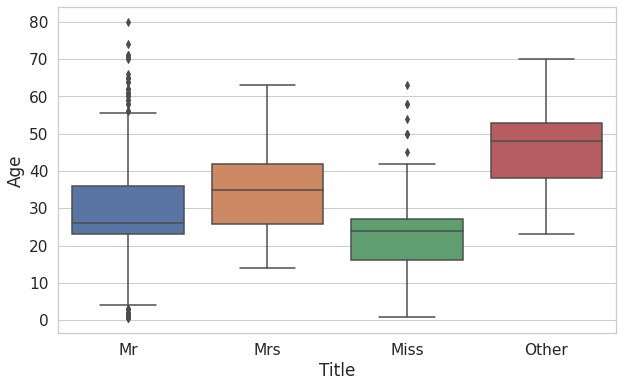

In [40]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Title',y='Age', data = train)

Now we can see that passengers with Other title name to whom belongs mainly passengers with honorific title are older than passengers with Mr, Mrs and Miss titles.
Let's check the survival grouped by Title of passangers.

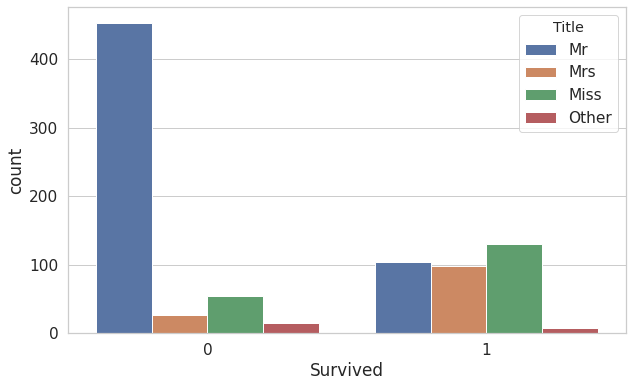

In [41]:
plt.figure(figsize=(10,6))
sns.countplot(x = 'Survived', data = train, hue = 'Title')

As we can see from the plot most passengers with Miss title died during the distater.
Let's make a dummy variable and use drop_first to avoid collinearity problems.

In [42]:
dummy_title = pd.get_dummies(train['Title'],drop_first=True,prefix='Title')

Let's remind what does Embarked mean.

In [43]:
titanic_dict['Embarked']

'Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)'

Let's make a dummy variable for embarked and sex as well.

In [44]:
dummy_embarked = pd.get_dummies(train['Embarked'],drop_first=True, prefix = 'Embarked')

In [45]:
dummy_sex = pd.get_dummies(train['Sex'],drop_first=True)

Now let's concat new dummy variables with our training dataset.

In [46]:
train = pd.concat([train,dummy_title,dummy_embarked,dummy_sex], axis = 1)

Let's drop unnecessary columns.

In [47]:
train.drop(['Name','Sex','Ticket','Title','Embarked'],axis = 1, inplace = True)

In [48]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Title_Mr,Title_Mrs,Title_Other,Embarked_Q,Embarked_S,male
PassengerId,,,,,,,,,,,,
1,0,3,22.000,1,0,7.250,1,0,0,0,1,1
2,1,1,38.000,1,0,71.283,0,1,0,0,0,0
3,1,3,26.000,0,0,7.925,0,0,0,0,1,0
4,1,1,35.000,1,0,53.100,0,1,0,0,1,0
5,0,3,35.000,0,0,8.050,1,0,0,0,1,1


Now we can move to use machine learning algorithms to predict whether a passenger survived or not.

## Test data cleaning 

Let's recreate the steps which we have already done on training data to test data.

In [49]:
test.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

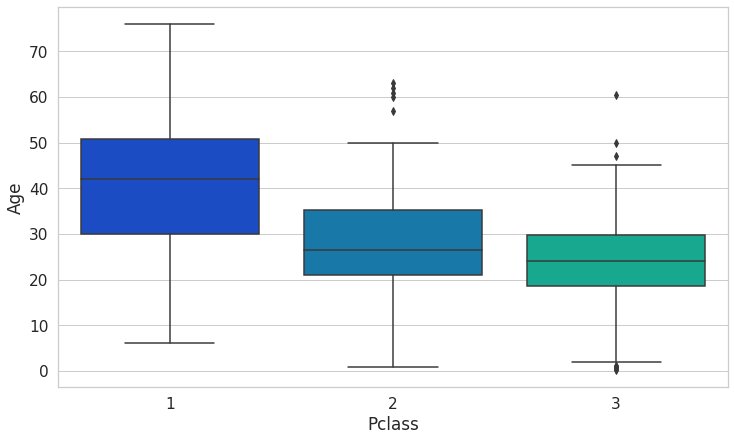

In [50]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=test,palette='winter')

In [51]:
def age_imputation_test(column):
    Age = column[0]
    Pclass = column[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return test[test["Pclass"]==1].mean()["Age"].round()
        elif Pclass == 2:
            return test[test["Pclass"]==2].mean()["Age"].round()
        elif Pclass == 3:
            return test[test["Pclass"]==3].mean()["Age"].round()
    else:
        return Age

In [52]:
test["Age"] = test[["Age","Pclass"]].apply(age_imputation_test,axis = 1)

In [53]:
test.isnull().sum()

Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

In [54]:
test['Cabin'].isnull().sum()/(test['Cabin'].count()+test['Cabin'].isnull().sum())*100

78.22966507177034

In [55]:
test.drop("Cabin", axis = 1, inplace = True)

We have one empty value on fare feature. Let's check if we can impute the fare based on Pclass column.

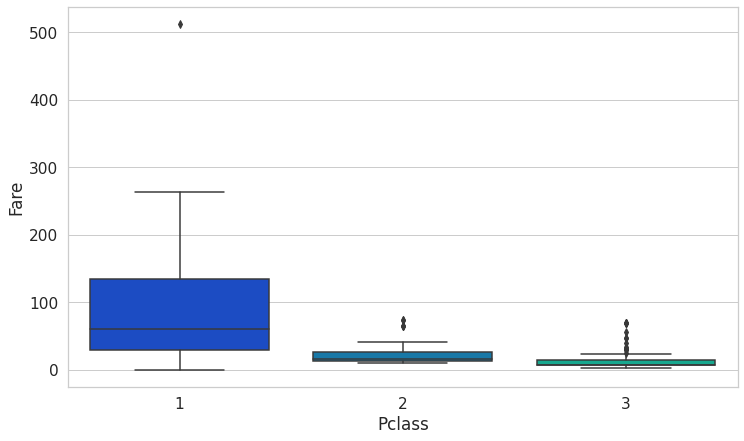

In [56]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Fare',data=test,palette='winter')

Let's now check what is the passenger who does not have Fare price.

In [57]:
test[test['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.500,0,0,3701,nan,S


In [58]:
titanic_dict['Pclass']

'Ticket class'

Let's fill this empty value by mean 3rd ticket class.

In [59]:
test.fillna(value = test[test['Pclass']==3].mean()['Fare'], inplace = True)

In [60]:
test[test['Name']=='Storey, Mr. Thomas']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.500,0,0,3701,12.460,S


In [61]:
test.isnull().sum()

Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

In [62]:
test['Title'] = test.Name.str.extract(r',\s([a-zA-Z ]+)', expand = True)

In [63]:
test['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dr          1
Dona        1
Ms          1
Name: Title, dtype: int64

Dona is feminine form for dom (title), titled nobility in Portugal and Brazil, and in English for certain Benedictine and Carthusian monks. Let's add this observation to others.

In [64]:
test['Title'] = test['Title'].replace(to_replace = 'Master',value = 'Mr')

In [65]:
test['Title'] = test['Title'].replace(to_replace = 'Ms',value = 'Miss')

In [66]:
test['Title'] = test['Title'].replace(to_replace = ['Dr','Rev','Col','Dona'],value = 'Other')

In [67]:
test['Title'].value_counts()

Mr       261
Miss      79
Mrs       72
Other      6
Name: Title, dtype: int64

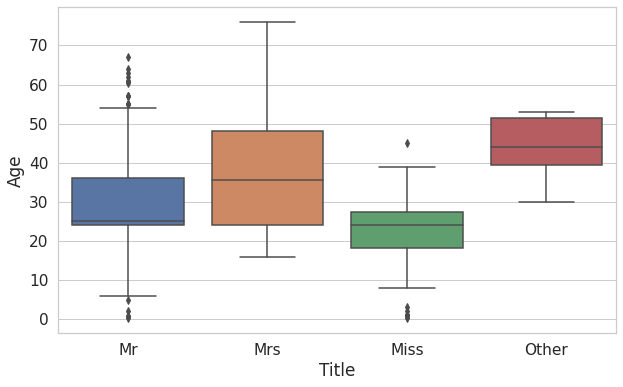

In [68]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Title',y='Age', data = test)

In [69]:
dummy_title_test = pd.get_dummies(test['Title'],drop_first=True,prefix='Title')

In [70]:
dummy_embarked_test = pd.get_dummies(test['Embarked'],drop_first=True, prefix = 'Embarked')

In [71]:
dummy_sex_test = pd.get_dummies(test['Sex'],drop_first=True)

In [72]:
test = pd.concat([test,dummy_title_test,dummy_embarked_test,dummy_sex_test], axis = 1)

In [73]:
test.drop(['Name','Sex','Ticket','Title','Embarked'],axis = 1, inplace = True)

In [74]:
test.head()

,Pclass,Age,SibSp,Parch,Fare,Title_Mr,Title_Mrs,Title_Other,Embarked_Q,Embarked_S,male
PassengerId,,,,,,,,,,,
892,3,34.500,0,0,7.829,1,0,0,1,0,1
893,3,47.000,1,0,7.000,0,1,0,0,1,0
894,2,62.000,0,0,9.688,1,0,0,1,0,1
895,3,27.000,0,0,8.662,1,0,0,0,1,1
896,3,22.000,1,1,12.287,0,1,0,0,1,0


## Data modelling - training data

In first step let's make a data frame to evaluate how good are our models on validation data by two metrics: F_score and AUC_score.

The F1 score is the harmonic mean of precision and recall taking both metrics into account in the following equation:

Precision is defined as the number of true positives divided by the number of true positives plus the number of false positives.
Recall is the number of true positives divided by the number of true positives plus the number of false negatives. 

AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:
- True Positive Rate (sensitivity, recall)
- False Positive Rate (1 - specificity)

Specificity is the number of true negatives divided by the number of true negativies plus the number of false positives

In [75]:
Evaluations = pd.DataFrame({'Model':[],'AUC_score':[],'F1_score':[]})

### Data splitting

As we have test data in different file let's split training data to training and validation set.

In [76]:
X = train.drop('Survived', axis = 1)
y = train['Survived']

In [77]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

In [78]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

### Logistic regression

After fitting Logistic Regression model let's check if there is a variable which does not have the statistical significance.

In [79]:
#features = ['Intercept','Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Title_Mr', 'Title_Mrs',
#'Title_Other', 'Embarked_Q', 'Embarked_S', 'male']

In [80]:
#logmodel_p_value = pd.DataFrame({'Feature':features,'p-value':stats.coef_pval(logmodel,X_train, y_train)})

In [81]:
#logmodel_p_value

If we assume that only variables which have got p-value < 0.05 are statistically significant, only one category Embarked_Q is not statistically significant.
Let's make a prediction.
Note: I did it using Jupyter Notebook, on kaggle from some reasons I am not able to import stats from regressors.

In [82]:
logmodel_predictions = logmodel.predict(X_val)

#### Checking if model is not overfitted on training data.

In [83]:
logmodel_train_predictions = logmodel.predict(X_train)

In [84]:
fpr_log_model, tpr_log_model, threshold = roc_curve(y_val, logmodel_predictions)
fpr_log_model_train, tpr_log_model_train, threshold = roc_curve(y_train, logmodel_train_predictions)


Text(0.5, 0, 'False Positive Rate')

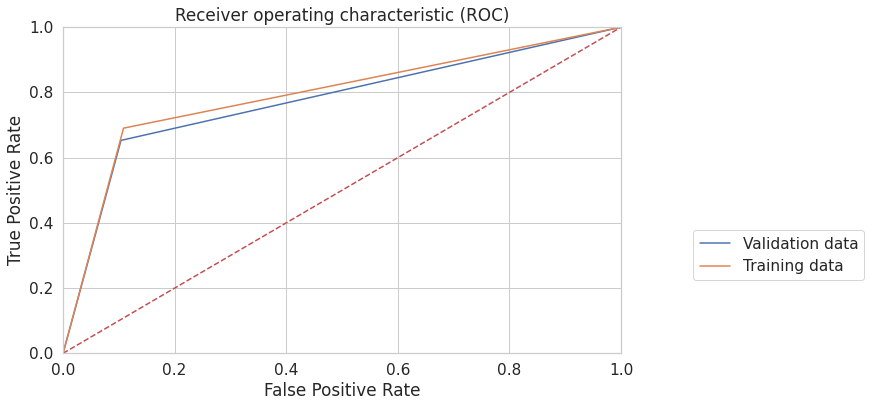

In [85]:
plt.figure(figsize=(10,6))
plt.plot(fpr_log_model, tpr_log_model, label = 'Validation data')
plt.plot(fpr_log_model_train, tpr_log_model_train, label = 'Training data')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc = 'lower right',bbox_to_anchor=(1.45, 0.2))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

We can see that ROC curve for training data is very similar to ROC curve for validation data. It means that model is not overfitted. 
Let's save the results in prepared dataframe.

In [86]:
Logmodel_evaluations = pd.DataFrame({'Model':['Logistic Regression'],
                                     'F1_score':[f1_score(y_val,logmodel_predictions)],
                                     'AUC_score':[roc_auc_score(y_val,logmodel_predictions)]})

In [87]:
Evaluations = Evaluations.append(Logmodel_evaluations)

### Classification tree

In [88]:
dtree = DecisionTreeClassifier()

In [89]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

In [90]:
d_tree_predictions = dtree.predict(X_val)

#### Checking if model is not overfitted on training data.

In [91]:
d_tree_train_predictions = dtree.predict(X_train)

In [92]:
fpr_d_tree, tpr_d_tree, threshold = roc_curve(y_val, d_tree_predictions)
fpr_d_tree_train, tpr_d_tree_train, threshold = roc_curve(y_train, d_tree_train_predictions)


Text(0.5, 0, 'False Positive Rate')

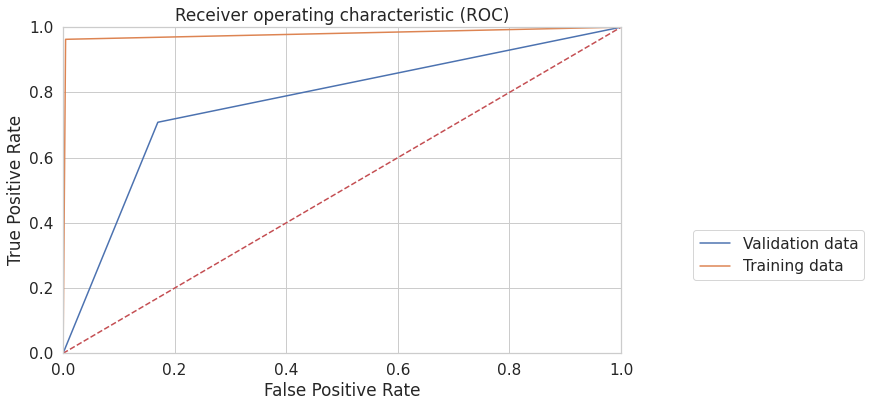

In [93]:
plt.figure(figsize=(10,6))
plt.plot(fpr_d_tree, tpr_d_tree, label = 'Validation data')
plt.plot(fpr_d_tree_train, tpr_d_tree_train, label = 'Training data')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc = 'lower right',bbox_to_anchor=(1.45, 0.2))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

We can see that our data is tailoted to data set. Let's prune the tree by setting max_depth parameter and check if it can help.

In [94]:
dtree = DecisionTreeClassifier(max_depth = 7)

In [95]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=7)

In [96]:
d_tree_predictions = dtree.predict(X_val)

In [97]:
d_tree_train_predictions = dtree.predict(X_train)

In [98]:
fpr_d_tree, tpr_d_tree, threshold = roc_curve(y_val, d_tree_predictions)
fpr_d_tree_train, tpr_d_tree_train, threshold = roc_curve(y_train, d_tree_train_predictions)


Text(0.5, 0, 'False Positive Rate')

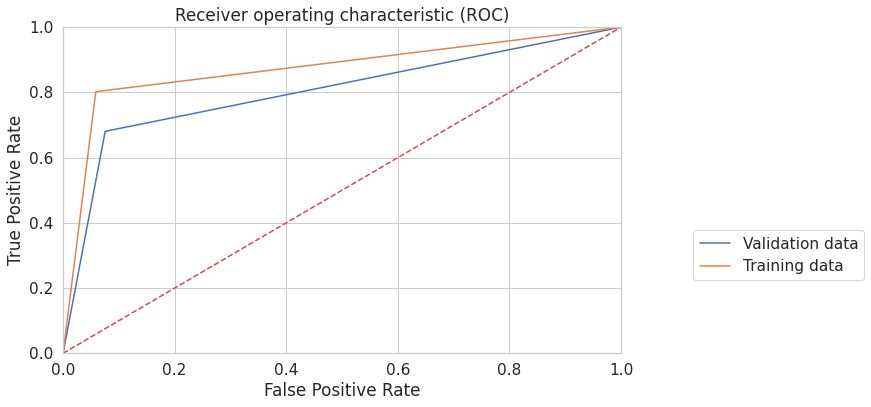

In [99]:
plt.figure(figsize=(10,6))
plt.plot(fpr_d_tree, tpr_d_tree, label = 'Validation data')
plt.plot(fpr_d_tree_train, tpr_d_tree_train, label = 'Training data')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc = 'lower right',bbox_to_anchor=(1.45, 0.2))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Now it looks much better. ROC curve for training data is closer to ROC curve for validation data than it was before pruning.
Let's save the results.

In [100]:
d_tree_evaluations = pd.DataFrame({'Model':['Classification tree'],
                                     'F1_score':[f1_score(y_val,d_tree_predictions)],
                                     'AUC_score':[roc_auc_score(y_val,d_tree_predictions)]})

In [101]:
Evaluations = Evaluations.append(d_tree_evaluations)

### Random forest

In [102]:
random_forest = RandomForestClassifier(n_estimators=100)

In [103]:
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [104]:
random_forest_predictions = random_forest.predict(X_val)

#### Checking if model is not overfitted on training data.

In [105]:
random_forest_train_predictions = random_forest.predict(X_train)

In [106]:
fpr_random_forest, tpr_random_forest, threshold = roc_curve(y_val, random_forest_predictions)
fpr_random_forest_train, tpr_random_forest_train, threshold = roc_curve(y_train, random_forest_train_predictions)

Text(0.5, 0, 'False Positive Rate')

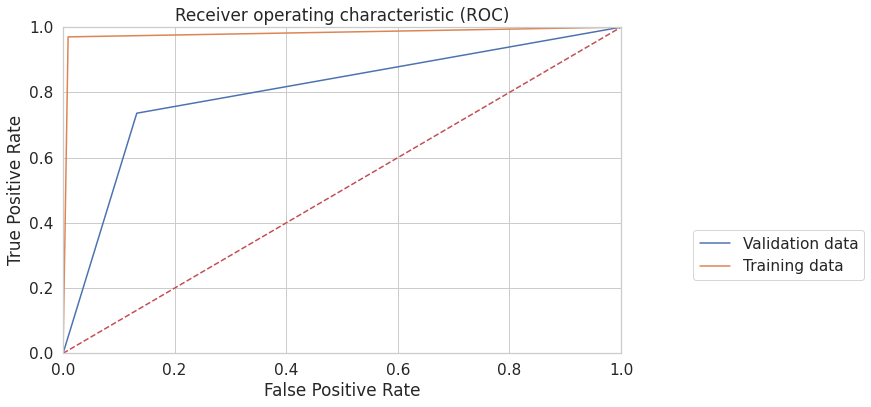

In [107]:
plt.figure(figsize=(10,6))
plt.plot(fpr_random_forest, tpr_random_forest, label = 'Validation data')
plt.plot(fpr_random_forest_train, tpr_random_forest_train, label = 'Training data')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc = 'lower right',bbox_to_anchor=(1.45, 0.2))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

We can see that our random forest is also overfitted. Let's prune a little by setting max_depth parameter.

In [108]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth = 6)

In [109]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=6)

In [110]:
random_forest_predictions = random_forest.predict(X_val)

In [111]:
random_forest_train_predictions = random_forest.predict(X_train)

In [112]:
fpr_random_forest, tpr_random_forest, threshold = roc_curve(y_val, random_forest_predictions)
fpr_random_forest_train, tpr_random_forest_train, threshold = roc_curve(y_train, random_forest_train_predictions)

Text(0.5, 0, 'False Positive Rate')

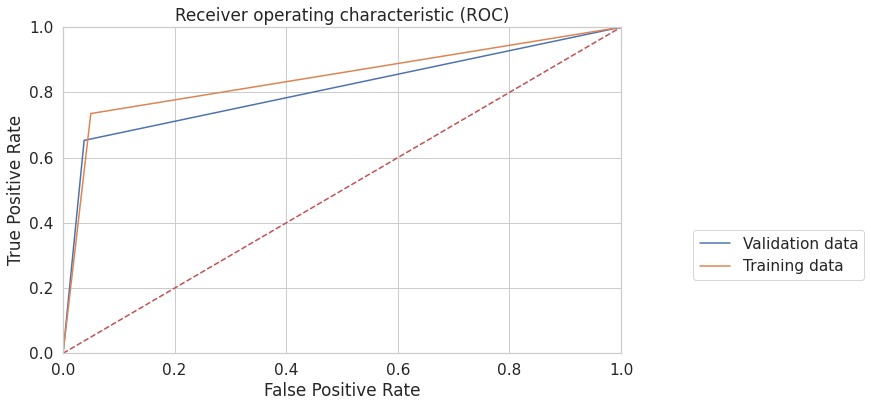

In [113]:
plt.figure(figsize=(10,6))
plt.plot(fpr_random_forest, tpr_random_forest, label = 'Validation data')
plt.plot(fpr_random_forest_train, tpr_random_forest_train, label = 'Training data')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc = 'lower right',bbox_to_anchor=(1.45, 0.2))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Now it looks much better. Let's save the results in our table!

In [114]:
random_forest_evaluations = pd.DataFrame({'Model':['Random forest'],
                                     'F1_score':[f1_score(y_val,random_forest_predictions)],
                                     'AUC_score':[roc_auc_score(y_val,random_forest_predictions)]})

In [115]:
Evaluations = Evaluations.append(random_forest_evaluations)

### Support vector machines with gridsearch

Gridsearch is the process of performing hyperparameter tuning in order to determine the optimal values for a given model. 

In [116]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [117]:
grid_svc = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)

In [118]:
grid_svc.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.622, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.627, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.627, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.620, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.620, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.622, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.627, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.620, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.620, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.622, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.648, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.634, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.641, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    4.8s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [119]:
grid_svc.best_params_

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}

In [120]:
grid_svc_predictions = grid_svc.predict(X_val)

#### Checking if model is not overfitted on training data.

In [121]:
grid_svc_train_predictions = grid_svc.predict(X_train)

In [122]:
fpr_svc, tpr_svc, threshold = roc_curve(y_val, grid_svc_predictions)
fpr_svc_train, tpr_svc_train, threshold = roc_curve(y_train, grid_svc_train_predictions)

Text(0.5, 0, 'False Positive Rate')

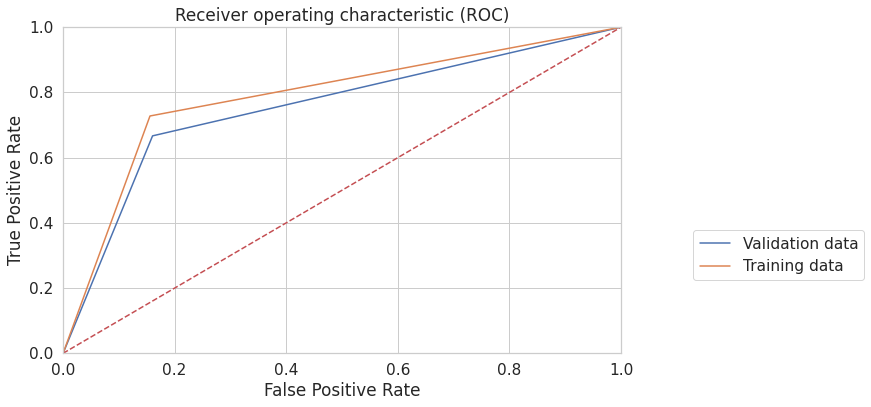

In [123]:
plt.figure(figsize=(10,6))
plt.plot(fpr_svc, tpr_svc, label = 'Validation data')
plt.plot(fpr_svc_train, tpr_svc_train, label = 'Training data')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc = 'lower right',bbox_to_anchor=(1.45, 0.2))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

ROC curve for training data is similar for ROC curve for validation data. Model is not overfitted so we can save the results!

In [124]:
grid_svc_evaluations = pd.DataFrame({'Model':['Support vector machines'],
                                     'F1_score':[f1_score(y_val,grid_svc_predictions)],
                                     'AUC_score':[roc_auc_score(y_val,grid_svc_predictions)]})

In [125]:
Evaluations = Evaluations.append(grid_svc_evaluations)

### Neural networks

The Adam optimization algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision and natural language processing.


In [126]:
X = train.drop('Survived', axis = 1).values
y = train['Survived'].values

In [127]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

In [128]:
X_train.shape

(711, 11)

In [129]:
neural_networks = Sequential()

neural_networks.add(Dense(units=11,activation='relu'))

neural_networks.add(Dense(units=6,activation='relu'))

neural_networks.add(Dense(units=1,activation='sigmoid'))

neural_networks.compile(loss='binary_crossentropy', optimizer='adam')
#The Adam optimization algorithm is an extension to stochastic gradient descent that has recently seen 
#broader adoption for deep learning applications in computer vision and natural language processing.
#https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

In [130]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
#https://keras.io/api/callbacks/

In [131]:
neural_networks.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_val, y_val), verbose=1,
          callbacks=[early_stop]
          )
#verbose for report
#patience = wait 25 after stoppoint

Epoch 1/600
23/23 [==============================] - 0s 9ms/step - loss: 14.8552 - val_loss: 12.6600
Epoch 2/600
23/23 [==============================] - 0s 3ms/step - loss: 10.2745 - val_loss: 8.0919
Epoch 3/600
23/23 [==============================] - 0s 2ms/step - loss: 5.4145 - val_loss: 2.6695
Epoch 4/600
23/23 [==============================] - 0s 2ms/step - loss: 1.4419 - val_loss: 0.9737
Epoch 5/600
23/23 [==============================] - 0s 2ms/step - loss: 0.8085 - val_loss: 0.7570
Epoch 6/600
23/23 [==============================] - 0s 2ms/step - loss: 0.6915 - val_loss: 0.7084
Epoch 7/600
23/23 [==============================] - 0s 2ms/step - loss: 0.6543 - val_loss: 0.6923
Epoch 8/600
23/23 [==============================] - 0s 2ms/step - loss: 0.6317 - val_loss: 0.6702
Epoch 9/600
23/23 [==============================] - 0s 2ms/step - loss: 0.6106 - val_loss: 0.6681
Epoch 10/600
23/23 [==============================] - 0s 2ms/step - loss: 0.6015 - val_loss: 0.6562
Epoch 

In [132]:
neural_networks_predictions = neural_networks.predict_classes(X_val)

In [133]:
neural_networks_evaluations = pd.DataFrame({'Model':['Neural networks'],
                                     'F1_score':[f1_score(y_val,neural_networks_predictions)],
                                     'AUC_score':[roc_auc_score(y_val,neural_networks_predictions)]})

In [134]:
Evaluations = Evaluations.append(neural_networks_evaluations)

In [135]:
fpr_neural_networks, tpr_neural_networks, threshold = roc_curve(y_val, neural_networks_predictions)

## Evaluations

In [136]:
Evaluations

,Model,AUC_score,F1_score
0,Logistic Regression,0.775,0.723
0,Classification tree,0.803,0.760
0,Random forest,0.808,0.764
0,Support vector machines,0.753,0.701
0,Neural networks,0.800,0.756


### Receiver operating characteristic (ROC)

Text(0.5, 0, 'False Positive Rate')

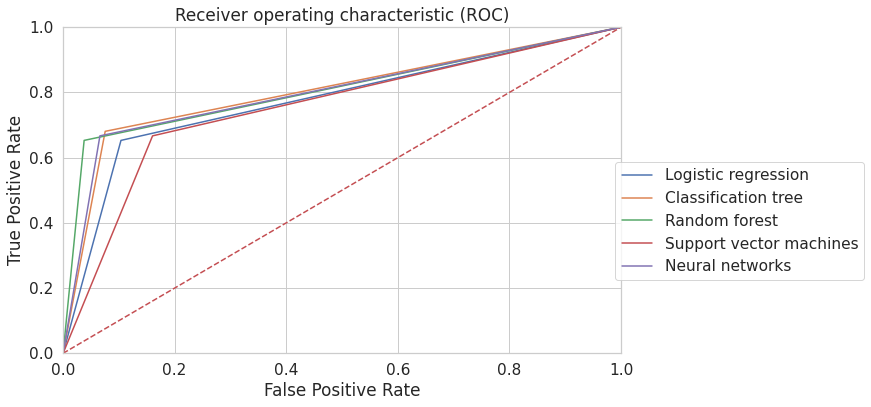

In [137]:
plt.figure(figsize=(10,6))
plt.plot(fpr_log_model, tpr_log_model, label = 'Logistic regression')
plt.plot(fpr_d_tree, tpr_d_tree, label = 'Classification tree')
plt.plot(fpr_random_forest, tpr_random_forest, label = 'Random forest')
plt.plot(fpr_svc, tpr_svc, label = 'Support vector machines')
plt.plot(fpr_neural_networks, tpr_neural_networks, label = 'Neural networks')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc = 'lower right',bbox_to_anchor=(1.45, 0.2))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

When we will compare the result and check the area under the ROC curve value we can annouce random forest as a best algorithm to predict survivals. Let's predict the test dependence variable and finish the project!

In [138]:
test_predictions = random_forest.predict(test)

In [139]:
Test_results = pd.DataFrame({'PassengerId':test.index,
                            'Survived':test_predictions})

In [140]:
Test_results.to_csv("Submission.csv",index=False)